In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# ================================================================
# 1. SYSTEM CONFIGURATION
# ================================================================
Nt = 8                # Number of BS antennas
K = 16                # Number of beams in codebook
N_SAMPLES = 50000     # Total dataset size
SEED = 42

# RIS parameters
M = 16                # Number of RIS elements
N_RIS_PATTERNS = 8    # Size of RIS phase codebook

np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# ================================================================
# 2. CODEBOOK GENERATION (DFT-BASED)
# ================================================================
def generate_dft_codebook(Nt, K):
    """Simple DFT-based beamforming codebook."""
    k_idx = np.arange(K)
    n_idx = np.arange(Nt).reshape(-1, 1)
    W = np.exp(1j * 2 * np.pi * n_idx * k_idx / K) / np.sqrt(Nt)
    return W

W_codebook = generate_dft_codebook(Nt, K)
print("Codebook shape:", W_codebook.shape)   # (Nt, K)

Codebook shape: (8, 16)


In [4]:
# ================================================================
# 3. CHANNEL GENERATION (RAYLEIGH + PATH LOSS)
# ================================================================
def generate_channel(Nt, batch_size=1, path_loss_db=-30):
    """
    Generate Rayleigh BS->User channels of size (batch_size, Nt).
    """
    h_real = np.random.randn(batch_size, Nt)
    h_imag = np.random.randn(batch_size, Nt)
    h = (h_real + 1j * h_imag) / np.sqrt(2.0)

    # Apply path loss
    path_loss_lin = 10 ** (path_loss_db / 10.0)
    h *= np.sqrt(path_loss_lin)
    return h  # shape: (batch_size, Nt)

# ================================================================
# 3a. RIS CONFIGURATION
# ================================================================
def generate_ris_phase_codebook(M, n_patterns, seed=123):
    """
    Simple RIS phase codebook: each pattern is a random phase vector.
    In advanced versions, these could be directional steering patterns.
    """
    rng = np.random.RandomState(seed)
    thetas = 2 * np.pi * rng.rand(n_patterns, M)  # random phases in [0, 2π)
    Phi = np.exp(1j * thetas)  # shape: (n_patterns, M)
    return Phi

RIS_PHASE_CODEBOOK = generate_ris_phase_codebook(M, N_RIS_PATTERNS)
print("RIS phase codebook shape:", RIS_PHASE_CODEBOOK.shape)  # (N_RIS_PATTERNS, M)


def generate_channel_matrix(M, Nt, batch_size=1, path_loss_db=-30):
    """
    Generate Rayleigh BS->RIS channel matrices of size (batch_size, M, Nt).
    """
    H_real = np.random.randn(batch_size, M, Nt)
    H_imag = np.random.randn(batch_size, M, Nt)
    H = (H_real + 1j * H_imag) / np.sqrt(2.0)

    path_loss_lin = 10 ** (path_loss_db / 10.0)
    H *= np.sqrt(path_loss_lin)
    return H  # shape: (batch_size, M, Nt)


def generate_ris_user_channel(M, batch_size=1, path_loss_db=-30):
    """
    Generate Rayleigh RIS->User channels of size (batch_size, M).
    """
    h_real = np.random.randn(batch_size, M)
    h_imag = np.random.randn(batch_size, M)
    h = (h_real + 1j * h_imag) / np.sqrt(2.0)

    path_loss_lin = 10 ** (path_loss_db / 10.0)
    h *= np.sqrt(path_loss_lin)
    return h  # shape: (batch_size, M)


RIS phase codebook shape: (8, 16)


In [5]:
# ================================================================
# 4. DATASET CREATION WITH RIS (FEATURES + LABELS)
# ================================================================
def build_dataset_ris(
    N_samples,
    Nt,
    K,
    W_codebook,
    M,
    RIS_PHASE_CODEBOOK,
    path_loss_direct_db=-30,
    path_loss_br_db=-30,
    path_loss_ru_db=-30,
):
    """
    Build a dataset where the effective channel includes:
    - Direct BS->User path
    - RIS-assisted BS->RIS->User path with random RIS phase patterns

    Label = best beam index for the effective channel.
    Features = real & imag parts of the effective channel (dimension 2*Nt).
    """
    X_list, y_list = [], []
    batch_size = 1000
    n_batches = int(np.ceil(N_samples / batch_size))
    n_patterns = RIS_PHASE_CODEBOOK.shape[0]

    for b in range(n_batches):
        current_bs = min(batch_size, N_samples - b * batch_size)

        # Direct BS -> User channel
        h_direct = generate_channel(
            Nt, batch_size=current_bs, path_loss_db=path_loss_direct_db
        )  # (current_bs, Nt)

        # BS -> RIS channel matrices
        H_BR = generate_channel_matrix(
            M, Nt, batch_size=current_bs, path_loss_db=path_loss_br_db
        )  # (current_bs, M, Nt)

        # RIS -> User channel vectors
        h_RU = generate_ris_user_channel(
            M, batch_size=current_bs, path_loss_db=path_loss_ru_db
        )  # (current_bs, M)

        # Effective channel storage
        h_eff = np.zeros((current_bs, Nt), dtype=np.complex128)

        # For each sample, choose a RIS phase pattern and compute effective channel
        for i in range(current_bs):
            pattern_idx = np.random.randint(0, n_patterns)
            phi = RIS_PHASE_CODEBOOK[pattern_idx]  # (M,)

            # RIS-assisted part: (1xM)*(1xM)->(1xM), then (1xM)@(MxNt)->(1xNt)
            h_ris_i = (h_RU[i] * phi) @ H_BR[i]  # (Nt,)

            # Total effective channel = direct + RIS-assisted
            h_eff[i, :] = h_direct[i, :] + h_ris_i

        # Beamforming gains with effective channel: (current_bs, Nt) @ (Nt, K) -> (current_bs, K)
        effective = h_eff @ W_codebook
        gains = np.abs(effective) ** 2
        labels = np.argmax(gains, axis=1)

        # Features: real + imag parts of effective channel
        feat_real = np.real(h_eff)
        feat_imag = np.imag(h_eff)
        feats = np.concatenate([feat_real, feat_imag], axis=1)

        X_list.append(feats.astype(np.float32))
        y_list.append(labels.astype(np.int64))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

# ---- Generate RIS-Aided Dataset ----
X, y = build_dataset_ris(
    N_SAMPLES,
    Nt,
    K,
    W_codebook,
    M,
    RIS_PHASE_CODEBOOK,
    path_loss_direct_db=-30,
    path_loss_br_db=-30,
    path_loss_ru_db=-30,
)
print("RIS Dataset shapes:", X.shape, y.shape)  # (N_SAMPLES, 2*Nt), (N_SAMPLES,)

RIS Dataset shapes: (50000, 16) (50000,)


In [6]:
# ================================================================
# 5. EXPORT DATASET TO EXCEL (OPTIONAL)
# ================================================================
columns = [f"h{i+1}_real" for i in range(Nt)] + [f"h{i+1}_imag" for i in range(Nt)]
df = pd.DataFrame(X, columns=columns)
df["best_beam_index"] = y

df.to_excel("beamforming_dataset_ris.xlsx", index=False)
print("Excel dataset saved as 'beamforming_dataset_ris.xlsx'.")

Excel dataset saved as 'beamforming_dataset_ris.xlsx'.


In [7]:
# ================================================================
# 6. TRAIN/VAL/TEST SPLIT
# ================================================================
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (35000, 16) Val: (7500, 16) Test: (7500, 16)


In [8]:
# ================================================================
# 7. PYTORCH DATASET + DATALOADER
# ================================================================
class BeamDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = BeamDataset(X_train, y_train)
val_ds   = BeamDataset(X_val, y_val)
test_ds  = BeamDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

In [9]:
# ================================================================
# 8. MODEL DEFINITION (MLP)
# ================================================================
input_dim = X_train.shape[1]   # should be 2*Nt
num_classes = K

class BeamMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BeamMLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 001 | Train Loss: 2.7730 | Train Acc: 0.0630 | Val Loss: 2.7720 | Val Acc: 0.0640
Epoch 002 | Train Loss: 2.7709 | Train Acc: 0.0708 | Val Loss: 2.7680 | Val Acc: 0.0884
Epoch 003 | Train Loss: 2.7606 | Train Acc: 0.1037 | Val Loss: 2.7477 | Val Acc: 0.1009
Epoch 004 | Train Loss: 2.7123 | Train Acc: 0.1452 | Val Loss: 2.6667 | Val Acc: 0.1777
Epoch 005 | Train Loss: 2.5911 | Train Acc: 0.1930 | Val Loss: 2.5213 | Val Acc: 0.1981
Epoch 006 | Train Loss: 2.4455 | Train Acc: 0.2260 | Val Loss: 2.3999 | Val Acc: 0.2295
Epoch 007 | Train Loss: 2.3401 | Train Acc: 0.2519 | Val Loss: 2.3142 | Val Acc: 0.2396
Epoch 008 | Train Loss: 2.2554 | Train Acc: 0.2741 | Val Loss: 2.2396 | Val Acc: 0.2689
Epoch 009 | Train Loss: 2.1791 | Train Acc: 0.2938 | Val Loss: 2.1686 | Val Acc: 0.2924
Epoch 010 | Train Loss: 2.1025 | Train Acc: 0.3166 | Val Loss: 2.0944 | Val Acc: 0.3113
Epoch 011 | Train Loss: 2.0311 | Train Acc: 0.3407 | Val Loss: 2.0186 | Val Acc: 0.3403
Epoch 012 | Train Loss: 1.9614 |

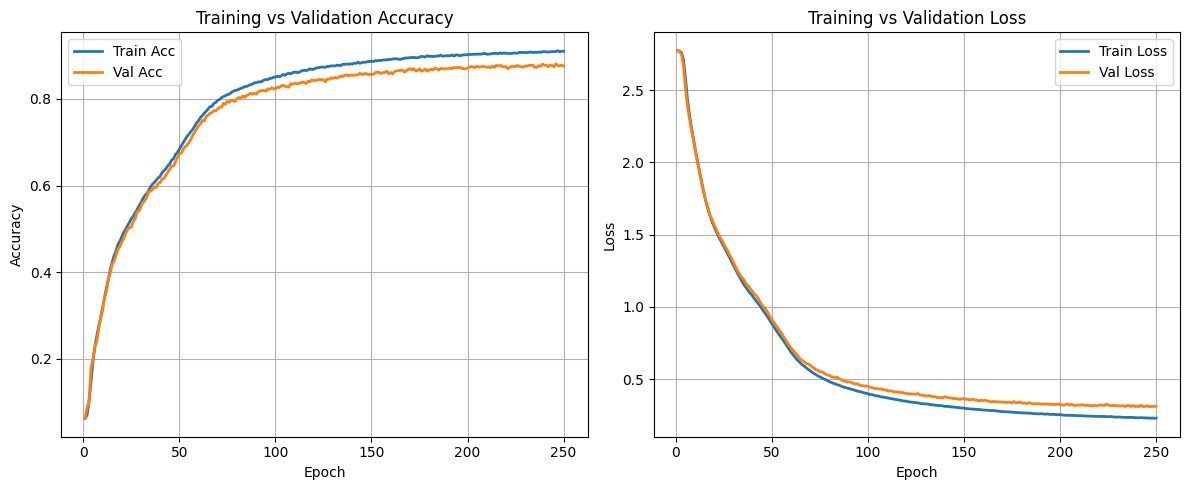

In [10]:
# ================================================================
# 9. TRAINING + VALIDATION + CURVE PLOTTING
# ================================================================
def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (torch.argmax(logits, dim=1) == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        correct += (torch.argmax(logits, dim=1) == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total


train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

best_val_acc = 0.0
best_state = None

EPOCHS = 250  # you can increase to 200–300 if you want

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

# ---------------------- PLOT THE CURVES ------------------------
epochs = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label='Train Acc', linewidth=2)
plt.plot(epochs, val_acc_list, label='Val Acc', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, label='Train Loss', linewidth=2)
plt.plot(epochs, val_loss_list, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# ================================================================
# 10. FINAL TEST METRICS
# ================================================================
test_loss, test_acc = evaluate(model, test_loader)
print("\n==============================")
print("Final Test Loss:", test_loss)
print("Final Test Accuracy:", test_acc)
print("==============================")


Final Test Loss: 0.3196514932632446
Final Test Accuracy: 0.8706666666666667


In [12]:
import shap

# ================================================================
# 11. XAI WITH SHAP (FEATURE IMPORTANCE)
# ================================================================
# Move model to CPU for SHAP and set eval mode
model_cpu = model.to("cpu")
model_cpu.eval()

def model_predict(x_numpy: np.ndarray) -> np.ndarray:
    """
    SHAP expects: input -> (N, F), output -> (N, num_classes)
    We return softmax probabilities of shape (N, K).
    """
    x_t = torch.from_numpy(x_numpy).float()
    with torch.no_grad():
        logits = model_cpu(x_t)
        probs = torch.softmax(logits, dim=1)
    return probs.numpy()

# ---------------------- BACKGROUND DATA -------------------------
# Use k-means to summarize background (faster)
background_clusters = 50
background = shap.kmeans(X_train, background_clusters)

# ---------------------- EXPLAIN SAMPLES ------------------------
test_explain_size = min(300, X_test.shape[0])
X_explain = X_test[:test_explain_size]

# ---------------------- EXPLAINER + SHAP VALUES ----------------
explainer = shap.KernelExplainer(model_predict, background)

# This can take a bit of time
shap_values = explainer.shap_values(X_explain)
# Here: shap_values is a list of length N_explain,
# each element of shape (n_features, n_beams)

print("len(shap_values):", len(shap_values))
print("shap_values[0].shape:", shap_values[0].shape)
print("X_explain.shape:", X_explain.shape)

# Stack into one array: (N, F, K)
sv_stack = np.stack(shap_values, axis=0)   # (N_explain, n_features, n_beams)
N_explain, n_features, n_beams = sv_stack.shape
print("Stacked SHAP shape:", sv_stack.shape)

# ------------------------------------------------
# AVERAGE OVER BEAMS -> (N_explain, n_features)
# ------------------------------------------------
# Take mean |SHAP| over all beams to get global feature importance
sv_mean_abs = np.mean(np.abs(sv_stack), axis=2)   # (N_explain, n_features)

print("Mean-abs SHAP shape:", sv_mean_abs.shape)  # should match (N_explain, n_features)



  0%|          | 0/300 [00:00<?, ?it/s]

len(shap_values): 300
shap_values[0].shape: (16, 16)
X_explain.shape: (300, 16)
Stacked SHAP shape: (300, 16, 16)
Mean-abs SHAP shape: (300, 16)


/tmp/ipython-input-2901592583.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


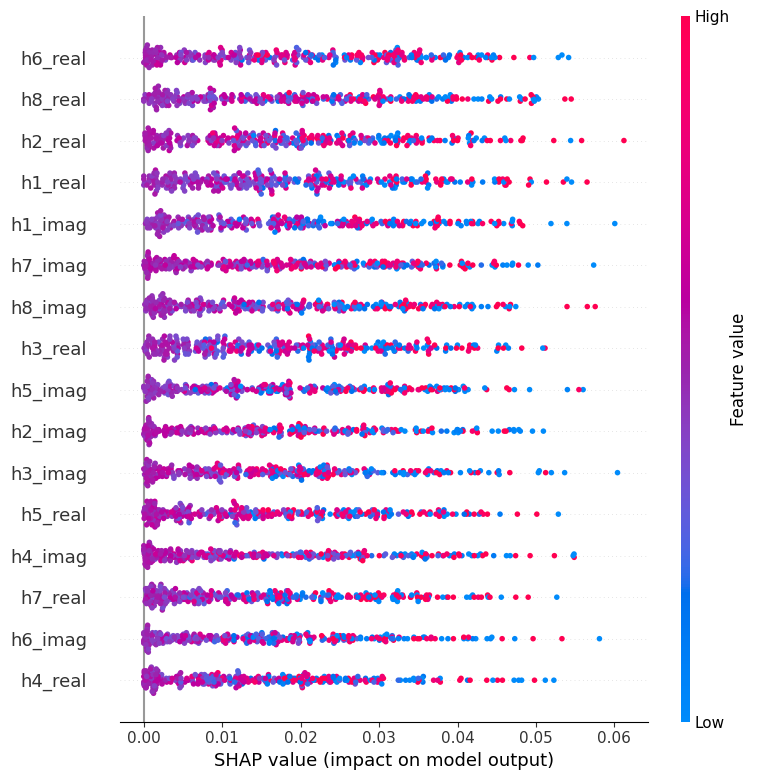

In [13]:
feature_names = columns  # [h1_real, ..., h8_real, h1_imag, ..., h8_imag]

# ================================================================
# 12. GLOBAL FEATURE IMPORTANCE PLOT
# ================================================================
shap.summary_plot(
    sv_mean_abs,
    X_explain,
    feature_names=feature_names,
    show=True
)